<a href="https://colab.research.google.com/github/ihsan02tempest/Batik-CNN-MobileNet-transfer-learning/blob/master/tflite_batik_TA_mobilenet_without_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TRAINING DATASET MOTIF BATIK MENGGUNAKAN PENDEKATAN MOBILENET DAN FRAMEWORK TENSORFLOWLITE

Sample yang dibutuhkan =
1. Motif Batik Corak Insang
2. Motif Batik Dayak
3. Motif Batik Megamendung
4. Motif Batik Ikat Celup

Source = https://www.kaggle.com/datasets/ihsan10/motif-batik-ta

In [ ]:
#@title MOUNT DATA DARI GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title ALOKASI AKSES KE FILE DATASET KAGGLE
! chmod 600 /content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/kaggle.json

In [ ]:
#@title AKSES PENYIMPANAN GOOGLE DRIVE UNTUK MENGIMPORT DATASET
! KAGGLE_CONFIG_DIR=/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/ kaggle datasets download -d ihsan10/motif-batik-ta

100% 35.8M/35.8M [00:03<00:00, 16.0MB/s]
100% 35.8M/35.8M [00:03<00:00, 11.8MB/s]


In [ ]:
#@title IMPORT DAN EKSTRAK ZIP YANG DIBUTUHKAN
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/gambar motif batik.zip')
zip_file.extractall('/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/')

In [ ]:
#@title IMPORT LIBRARY YANG DIBUTUHKAN
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, InputLayer, ZeroPadding2D, BatchNormalization, DepthwiseConv2D
from keras.preprocessing import image
from keras.optimizers import Adam
from keras import regularizers
from tensorflow import keras
from tensorflow import lite
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_cpu_global_jit"

In [ ]:
#@title PENENTUAN PARAMETER PELATIHAN DATA
img_width, img_height = 128, 128

train_data_dir = '/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/gambar motif batik/TRAIN'
validation_data_dir = '/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/gambar motif batik/VALIDATION'
test_data_dir = '/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/gambar motif batik/TEST'

label_class = ["Batik Corak Insang", "Batik Dayak", "Batik Ikat Celup", "Batik Megamendung"]
image_size = 128
num_train = 100
num_test = 20
num_val = 10

In [ ]:
#@title PRE-PROCESSING
train_datagen = ImageDataGenerator( rescale = 1/255,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')

validation_datagen = ImageDataGenerator( rescale = 1/255 )

test_datagen = ImageDataGenerator( rescale = 1/255 )

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    classes=label_class,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size = (128, 128))

validation_generator = test_datagen.flow_from_directory(validation_data_dir, 
                                                    batch_size=16,
                                                    classes=label_class,
                                                    class_mode='categorical',
                                                    target_size = (128, 128),
                                                    shuffle=False)

test_generator = test_datagen.flow_from_directory(test_data_dir, 
                                                    batch_size=16,
                                                    classes=label_class,
                                                    class_mode='categorical',
                                                    target_size = (128, 128),
                                                    shuffle=False)

Found 440 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [ ]:
#@title MODEL ARSITEKTUR MOBILENET (CNN DEPTHWISE SEPARABLE CONVOLUTION)
model = Sequential()
model.add(InputLayer(input_shape=(128,128,3), name='input_layer'))

#layer 1
model.add(ZeroPadding2D(((0,1),(0,1)), name='Conv2D_1_Pad'))
model.add(Conv2D(32, kernel_size=(3,3), strides=(2,2), kernel_regularizer=regularizers.l1(0.01), name='Conv2D_1'))
model.add(BatchNormalization(axis=1, name='Conv2D_1_Bn'))

model.add(Activation(('relu'), name='Conv2D_1_Relu'))
model.add(DepthwiseConv2D(kernel_size=(3,3),strides=(1,1), kernel_regularizer=regularizers.l1(0.01), padding='same', depth_multiplier=1, use_bias=False, name='ConvDw2D_1'))
model.add(BatchNormalization(axis=1, name='ConvDw2D_1_Bn'))
model.add(Activation(('relu'), name='ConvDw2D_1_Relu'))
model.add(Conv2D(64, kernel_size=(1,1), strides=(1,1), name='ConvPw2D_1' ))
model.add(BatchNormalization(axis=1, name='ConvPw2D_1_Bn'))
model.add(Activation(('relu'), name='ConvPw2D_1_Relu'))

#Layer 2
model.add(ZeroPadding2D(((0,1),(0,1)), name='Conv2D_2_Pad'))
model.add(DepthwiseConv2D(kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l1(0.01), strides=(2,2), depth_multiplier=1, use_bias=False, name='ConvDw2D_2'))
model.add(BatchNormalization(axis=1, name='ConvDw2D_2_Bn'))
model.add(Activation(('relu'), name='ConvDw2D_2_Relu'))
model.add(Conv2D(128, kernel_size=(1,1), strides=(1,1), name='ConvPw2D_2' ))
model.add(BatchNormalization(axis=1, name='ConvPw2D_2_Bn'))
model.add(Activation(('relu'), name='ConvPw2D_2_Relu'))

#Layer 3
model.add(ZeroPadding2D(((0,1),(0,1)), name='Conv2D_3_Pad'))
model.add(DepthwiseConv2D(kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l1(0.01), strides=(1,1), depth_multiplier=1, use_bias=False, name='ConvDw2D_3'))
model.add(BatchNormalization(axis=1, name='ConvDw2D_3_Bn'))
model.add(Activation(('relu'), name='ConvDw2D_3_Relu'))
model.add(Conv2D(128, kernel_size=(1,1), strides=(1,1), name='ConvPw2D_3' ))
model.add(BatchNormalization(axis=1, name='ConvPw2D_3_Bn'))
model.add(Activation(('relu'), name='ConvPw2D_3_Relu'))

#Average Pooling
model.add(GlobalAveragePooling2D())

#Fully-Connected
model.add(Dropout(0.25))
predictions = model.add(Dense(4, activation = 'softmax'))

In [ ]:
#@title CEK SUMMARY TRAINING MODEL
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1_Pad (ZeroPadding2D  (None, 129, 129, 3)      0         
 )                                                               
                                                                 
 Conv2D_1 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 Conv2D_1_Bn (BatchNormaliza  (None, 64, 64, 32)       256       
 tion)                                                           
                                                                 
 Conv2D_1_Relu (Activation)  (None, 64, 64, 32)        0         
                                                                 
 ConvDw2D_1 (DepthwiseConv2D  (None, 64, 64, 32)       288       
 )                                                               
                                                        

In [ ]:
#@title COMPILE MASUKAN
opt = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#@title CHECKPOINT PENYIMPANAN MODEL
#import ModelCheckpoint
from keras.callbacks import ModelCheckpoint

#menentukan path folder menyimpan model
filepath = '/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/my-saved-model/model8/model-batik.h5'

In [ ]:
#@title MENYIMPAN MODEL DENGAN KRITERIA TERBAIK
checkpoint = ModelCheckpoint(filepath,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

In [ ]:
#@title TRANING MODEL
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=10,
                    epochs=100,
                    validation_steps=10,
                    callbacks=[checkpoint],
                    verbose=1,
                    use_multiprocessing=True,
                    workers=4)

Epoch 1/100
10/10 [==============================] - 46s 3s/step - loss: 2.0952 - accuracy: 0.2500 - val_loss: 1.9401 - val_accuracy: 0.2500
Epoch 2/100
10/10 [==============================] - 36s 3s/step - loss: 1.8583 - accuracy: 0.3654 - val_loss: 1.8899 - val_accuracy: 0.2500
Epoch 3/100
10/10 [==============================] - 39s 3s/step - loss: 1.7770 - accuracy: 0.4031 - val_loss: 1.8507 - val_accuracy: 0.2500
Epoch 4/100
10/10 [==============================] - 33s 3s/step - loss: 1.6333 - accuracy: 0.4750 - val_loss: 1.8208 - val_accuracy: 0.2500
Epoch 5/100
10/10 [==============================] - 31s 2s/step - loss: 1.5589 - accuracy: 0.4968 - val_loss: 1.7982 - val_accuracy: 0.2500
Epoch 6/100
10/10 [==============================] - 34s 3s/step - loss: 1.4488 - accuracy: 0.5417 - val_loss: 1.7804 - val_accuracy: 0.2500
Epoch 7/100
10/10 [==============================] - 35s 3s/step - loss: 1.4149 - accuracy: 0.5353 - val_loss: 1.7638 - val_accuracy: 0.2500
Epoch 8/100
1

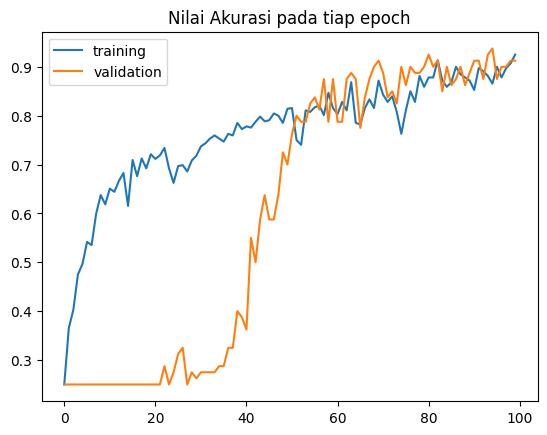

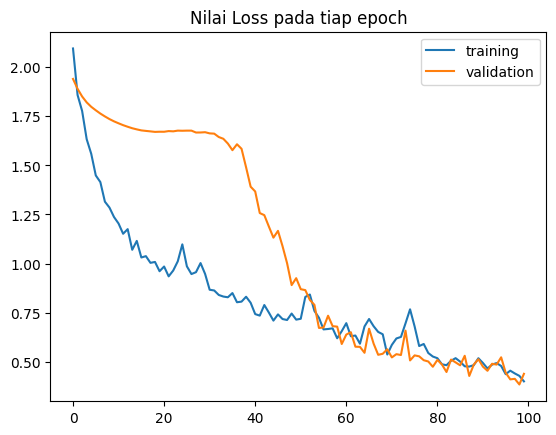

In [ ]:
#@title GRAFIK NILAI AKURASI TRAINING DAN VALIDASI
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Nilai Akurasi pada tiap epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Nilai Loss pada tiap epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [ ]:
#@title EVALUASI MODEL
model.load_weights(filepath)
train_loss, train_accuracy = model.evaluate(train_generator, verbose=2)
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=2)

14/14 - 15s - loss: 0.3576 - accuracy: 0.9409 - 15s/epoch - 1s/step
5/5 - 2s - loss: 0.3844 - accuracy: 0.9125 - 2s/epoch - 363ms/step


In [ ]:
model.save('/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/my-saved-model/model8/model-batik.h5')
loaded_model=tf.keras.models.load_model('/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/my-saved-model/model8/model-batik.h5')

In [ ]:
loaded_model_json = loaded_model.to_json()
with open('loaded_model.json', 'w') as json_file:
    json_file.write(loaded_model_json)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/my-saved-model/model8/converted_model.tflite", "wb").write(tflite_model)

137460

In [ ]:
#@title CONFUSION MATRIX DAN KLASIFIKASI REPORT
model.load_weights(filepath)
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())
report = metrics.classification_report(test_generator.classes, predicted_classes, target_names=class_labels)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_classes))
print('Classification Report')
print(report)

8/8 [==============================] - 13s 2s/step
Confusion Matrix
[[27  2  0  1]
 [ 0 29  0  1]
 [ 0  1 28  1]
 [ 1  1  3 25]]
Classification Report
                    precision    recall  f1-score   support

Batik Corak Insang       0.96      0.90      0.93        30
       Batik Dayak       0.88      0.97      0.92        30
  Batik Ikat Celup       0.90      0.93      0.92        30
 Batik Megamendung       0.89      0.83      0.86        30

          accuracy                           0.91       120
         macro avg       0.91      0.91      0.91       120
      weighted avg       0.91      0.91      0.91       120



In [ ]:
#@title HITUNG LANGSUNG AKURASI, PRESISI, RECALL, DAN F1-SCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# hitung akurasi
accuracy = accuracy_score(test_generator.classes, predicted_classes)

# hitung presisi
precision = precision_score(test_generator.classes, predicted_classes, average='weighted')

# hitung recall
recall = recall_score(test_generator.classes, predicted_classes, average='weighted')

# hitung f1-score
f1 = f1_score(test_generator.classes, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.9083333333333333
Precision: 0.9097891355955873
Recall: 0.9083333333333333
F1-Score: 0.9079427889490072


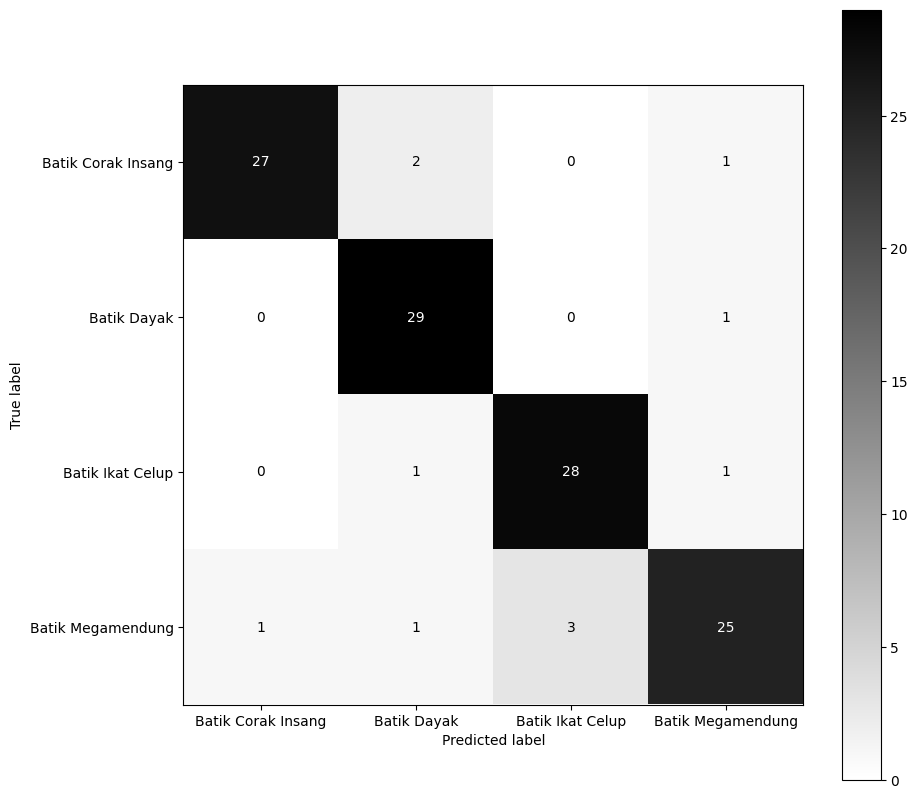

In [ ]:
#@title DISPLAY HASIL DARI EVALUASI CONFUSION MATRIX
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(test_generator.classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)

disp.plot(cmap=plt.cm.binary, ax=ax)
plt.show()